In [1]:
%pip install -e .
from nbgui import nbgui



Obtaining file:///Users/marc/nbgui
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for nbgui (pyproject.toml) ... done
  Created wheel for nbgui: filename=nbgui-0.1.0-0.editable-py3-none-any.whl size=1694 sha256=7f42ac55d7d67ec106d09420ef2a80c2bbcac5a496da65c24d4482c842bb4494
  Stored in directory: /private/var/folders/zl/vpmwgj713nd_65_7rm204fch0000gn/T/pip-ephem-wheel-cache-tej1w_tl/wheels/9e/be/98/16cb7b7b2b5c11447bd7a4a7f68b1fdc06125d041c2594af5c
Successfully built nbgui
  Attempting uninstall: nbgui
    Found existing installation: nbgui 0.1.0
    Uninstalling nbgui-0.1.0:
      Successfully uninstalled nbgui-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
gui = nbgui()

RFBOutputContext()

Resize Event - logical_size: (1280.0, 1024.0), pixel_ratio: 1


nbgui(css_height='1024px', css_width='1280px')
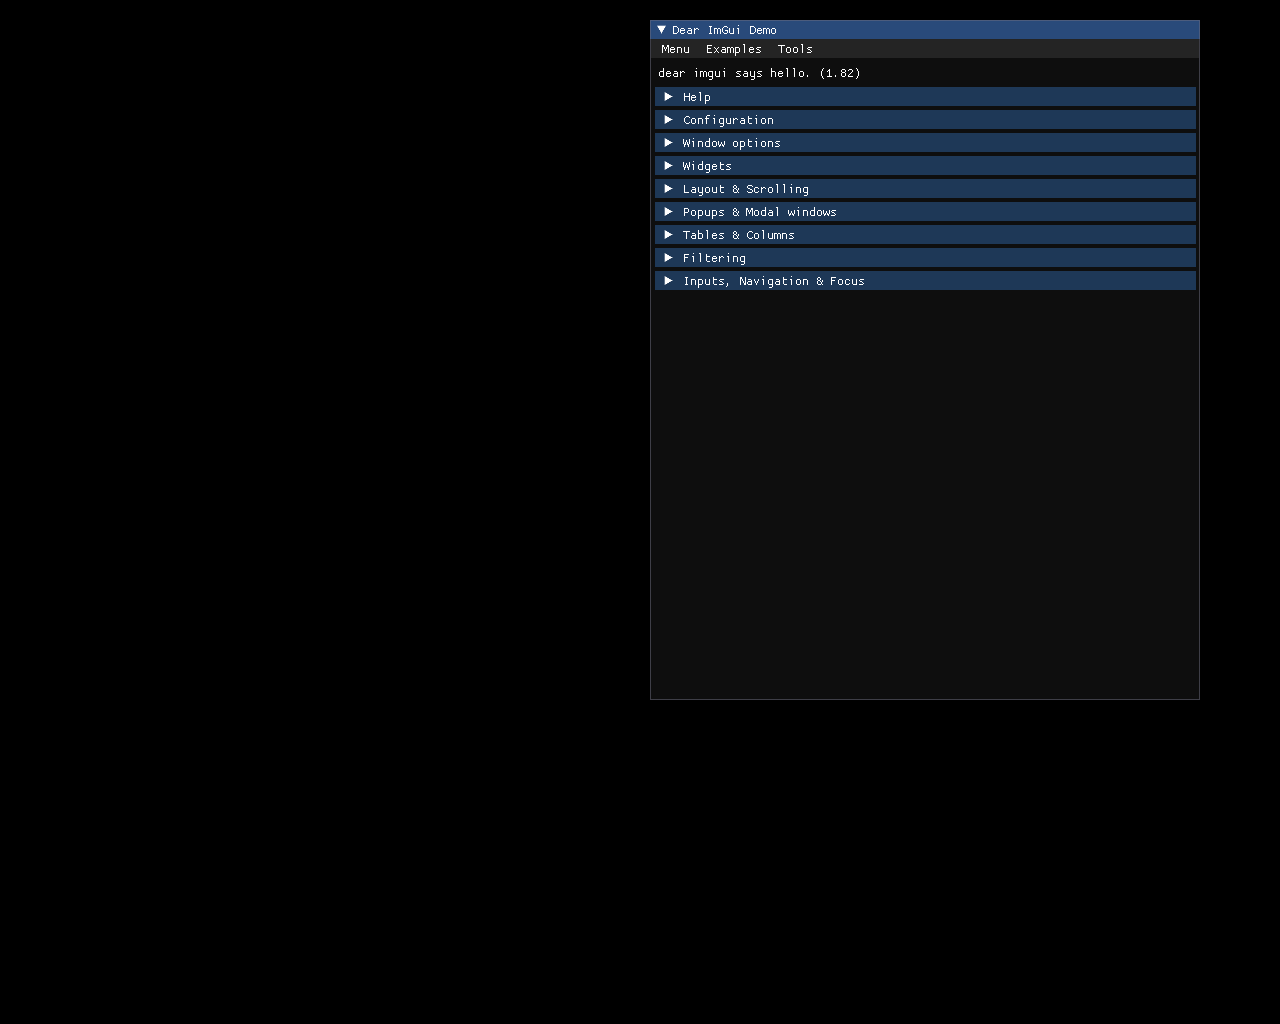

In [3]:
gui